In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import seaborn as sns


In [2]:
from sqlalchemy import create_engine
engine = create_engine('postgres://bella@localhost:5432/politifact_db')

In [3]:
df = pd.read_sql_query('SELECT * FROM "statements"', con=engine)

In [4]:
df['year'] = pd.DatetimeIndex(df['time']).year



In [5]:
rulings = ["True", "Mostly True", "Half-True", "Mostly False", "False", "Pants on Fire!"]
all_rulings = ["True", "Mostly True", "Half-True", "Mostly False", "False", "Pants on Fire!", "No Flip", "Half Flip", "Full Flop"]

df['ruling_int'] = df['ruling'].map(lambda x: all_rulings.index(x))
df

,id,statement,statement_link,ruling,ruling_text,time,source,source_image,year,ruling_int
0,5939,On timing of right to work legislation,http://www.politifact.com/wisconsin/statements...,Half Flip,Elections matter.,2014-12-10,Robin Vos,http://static.politifact.com.s3.amazonaws.com/...,2014,7
1,14360,On support for gay marriage.,http://www.politifact.com/truth-o-meter/statem...,Full Flop,"For it, against it, for it again",2012-05-11,Barack Obama,http://static.politifact.com.s3.amazonaws.com/...,2012,8
2,15751,Says Rick Perry cut taxes.,http://www.politifact.com/texas/statements/201...,Half-True,"Some up, some down",2012-01-13,Craig James,http://static.politifact.com.s3.amazonaws.com/...,2012,2
3,4166,"""I released all my emails.""",http://www.politifact.com/florida/statements/2...,Mostly False,He picked what emails were made public,2015-08-31,Jeb Bush,http://static.politifact.com.s3.amazonaws.com/...,2015,3
4,4604,"A ""working woman"" will earn $7.70 on $10.",http://www.politifact.com/georgia/statements/2...,Mostly True,Details are the stumbling blocks,2015-07-10,Tom Toles,http://static.politifact.com.s3.amazonaws.com/...,2015,1
5,5666,"""Al-Qaida has grown fourfold in five years.""",http://www.politifact.com/punditfact/statement...,Half-True,It's hard to quantify al-Qaida,2015-02-01,Jack Keane,http://static.politifact.com.s3.amazonaws.com/...,2015,2
6,5721,"""America is No. 1 in wind power.""",http://www.politifact.com/truth-o-meter/statem...,Mostly True,"U.S. is tops in generation, but not capacity",2015-01-21,Barack Obama,http://static.politifact.com.s3.amazonaws.com/...,2015,1
7,6096,110 people a day move to Austin.,http://www.politifact.com/texas/statements/201...,Mostly False,Looks like a regional estimate,2014-11-14,Lynda Rife,http://static.politifact.com.s3.amazonaws.com/...,2014,3
8,7854,"Dan Branch ""once lobbied for the AFL-CIO.""",http://www.politifact.com/texas/statements/201...,False,Bending Branch,2014-05-15,Ken Paxton,http://static.politifact.com.s3.amazonaws.com/...,2014,4
9,8601,"""Worked with Ronald Reagan and helped re-elect...",http://www.politifact.com/texas/statements/201...,Half-True,With the Gipper from a distance,2014-02-21,Dan Branch,http://static.politifact.com.s3.amazonaws.com/...,2014,2


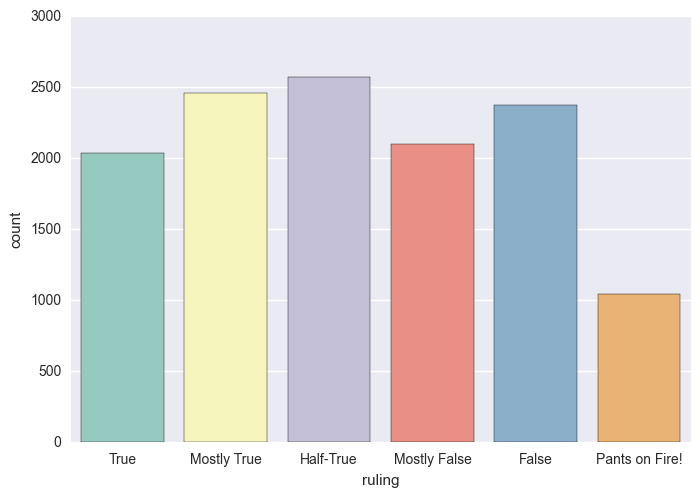

In [6]:

# Histogram of Politifact Database
sns.countplot(x="ruling", data=df, palette="Set3", order = rulings)
plt.figure()

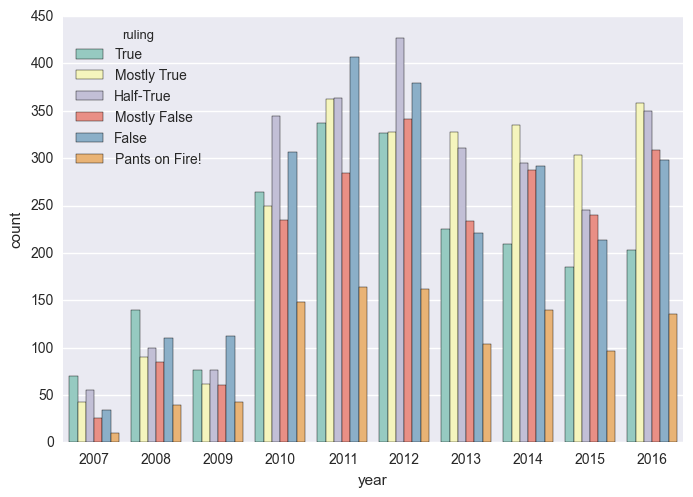

In [7]:
sns.countplot(x="year", hue="ruling", data=df, palette="Set3", hue_order = rulings)


In [8]:
df = df[(df.ruling == "True") | (df.ruling == "Mostly True") | (df.ruling == "Half-True") | (df.ruling == "False") | (df.ruling == "Mostly False") | (df.ruling == "Pants on Fire!")]
yearly_totals = df['year'].value_counts()
yearly_totals

2012    1964
2011    1918
2016    1653
2014    1559
2010    1548
2013    1423
2015    1283
2008     564
2009     430
2007     238
Name: year, dtype: int64

In [9]:
yearly_totals[2009]

430

In [10]:
# Create text files with binary classification -- truthy and falsey
# df[(df.ruling == "True") | (df.ruling == "Mostly True") | (df.ruling == "Half-True")].to_csv('true_statements.txt', columns=['statement'], encoding='utf-8', index=False, header=False)
# df[(df.ruling == "False") | (df.ruling == "Mostly False") | (df.ruling == "Pants on Fire!")].to_csv('false_statements.txt', columns=['statement'], encoding='utf-8', index=False, header=False)
# df[(df.ruling == "True") | (df.ruling == "Mostly True") | (df.ruling == "Half-True") | (df.ruling == "False") | (df.ruling == "Mostly False") | (df.ruling == "Pants on Fire!")].to_csv('all_statements.txt', columns=['statement', 'ruling_int'], encoding='utf-8', index=False, header=False, sep='\t')

In [11]:
from nltk.tokenize import PunktWordTokenizer
punkt_word_tokenizer = PunktWordTokenizer()

wnl = nltk.WordNetLemmatizer()

In [12]:
def make_full_dict(words):
    return dict([(word, True) for word in words])

wordlists = {}
fdists = {}
fdistscommon = {}
features = {}

for ruling in rulings:
    wordlists[ruling] = []
    features[ruling] = []
    for statement in df[df.ruling == ruling].statement:
        words = punkt_word_tokenizer.tokenize(statement)
#         words = re.findall(r"[\w']+|[.,!?;]", statement.rstrip())
        wordlists[ruling] += words
        features[ruling].append([make_full_dict(wordlists[ruling]), ruling])

    # Remove punctuation, prepositions, determiners, and conjunctions as candidates for most frequent tokens
    fdists[ruling] = nltk.FreqDist(wnl.lemmatize(w.lower()) for w in wordlists[ruling] if w.isalpha() and (nltk.pos_tag([w])[0][1] not in ['IN', 'TO', 'DT', 'CC']))
    fdistscommon[ruling] = fdists[ruling].most_common(40)

In [15]:
fddf = pd.DataFrame.from_dict(fdistscommon)
fddf = fddf[rulings] # sort columns in order of rulings 

def highlight_obama(val):
    if val[0] == "obama":
        return 'background-color: yellow' 
    if val[0] == "barack":
        return 'background-color: orange' 
    elif val[0] == "percent":
        return 'background-color: pink'
    elif val[0] == "job":
        return 'background-color: lavender'
    elif val[0] == "president":
        return 'background-color: SkyBlue'
    else:
        return ''

s = fddf.style.applymap(highlight_obama)

s

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [17]:
statements_list = df[(df.ruling == "True") | (df.ruling == "Mostly True") | (df.ruling == "Half-True") | (df.ruling == "False") | (df.ruling == "Mostly False") | (df.ruling == "Pants on Fire!")]['statement'].tolist()

In [18]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


# tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
#                                  min_df=0.2, stop_words='english',
#                                  use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')

%time tfidf_matrix = tfidf_vectorizer.fit_transform(statements_list) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 1.9 s, sys: 247 ms, total: 2.15 s
Wall time: 2.72 s
(12580, 191183)


In [19]:
terms = tfidf_vectorizer.get_feature_names()
len(terms)

191183

In [20]:
statements_list

[u' Says Rick Perry cut taxes. ',
 u'"I released all my emails." ',
 u'A "working woman" will earn $7.70 on $10. ',
 u'"Al-Qaida has grown fourfold in five years."\xa0 ',
 u'"America is No. 1 in wind power." ',
 u'110 people a day move to Austin. ',
 u'Dan Branch "once lobbied for the AFL-CIO." ',
 u'"Worked with Ronald Reagan and helped re-elect him." ',
 u'Travis County is "surrounded by red counties." ',
 u'Says "Harry Reid has a better voting attendance record than these three Congressmen!" ',
 u'Says Chris Christie fired 6,000 teachers. ',
 u'"I was filibustered." ',
 u' "Forty-seven percent of (members of Congress) are millionaires." ',
 u' "In every state, women are paid less than men." ',
 u' On new dollar coins, "\'In God We Trust\' is gone!" ',
 u'Says opponent Beto O\u2019Rourke "wants to legalize drugs." ',
 u' "We\'re bankrupt."',
 u' "I stopped requesting earmarks in 2008."',
 u' "There\u2019s a mosque inside of the Pentagon." ',
 u'The Iraq war has been "our longest war.

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print(dist[0][1])

1.0


In [22]:
from sklearn.cluster import KMeans

num_clusters = 6

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 21.8 s, sys: 2 s, total: 23.8 s
Wall time: 23.9 s


In [23]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [24]:
df = df[(df.ruling == "True") | (df.ruling == "Mostly True") | (df.ruling == "Half-True") | (df.ruling == "False") | (df.ruling == "Mostly False") | (df.ruling == "Pants on Fire!")]
df['clusters'] = clusters
df # Show clusters each statement belongs to

,id,statement,statement_link,ruling,ruling_text,time,source,source_image,year,ruling_int,clusters
2,15751,Says Rick Perry cut taxes.,http://www.politifact.com/texas/statements/201...,Half-True,"Some up, some down",2012-01-13,Craig James,http://static.politifact.com.s3.amazonaws.com/...,2012,2,3
3,4166,"""I released all my emails.""",http://www.politifact.com/florida/statements/2...,Mostly False,He picked what emails were made public,2015-08-31,Jeb Bush,http://static.politifact.com.s3.amazonaws.com/...,2015,3,0
4,4604,"A ""working woman"" will earn $7.70 on $10.",http://www.politifact.com/georgia/statements/2...,Mostly True,Details are the stumbling blocks,2015-07-10,Tom Toles,http://static.politifact.com.s3.amazonaws.com/...,2015,1,0
5,5666,"""Al-Qaida has grown fourfold in five years.""",http://www.politifact.com/punditfact/statement...,Half-True,It's hard to quantify al-Qaida,2015-02-01,Jack Keane,http://static.politifact.com.s3.amazonaws.com/...,2015,2,4
6,5721,"""America is No. 1 in wind power.""",http://www.politifact.com/truth-o-meter/statem...,Mostly True,"U.S. is tops in generation, but not capacity",2015-01-21,Barack Obama,http://static.politifact.com.s3.amazonaws.com/...,2015,1,0
7,6096,110 people a day move to Austin.,http://www.politifact.com/texas/statements/201...,Mostly False,Looks like a regional estimate,2014-11-14,Lynda Rife,http://static.politifact.com.s3.amazonaws.com/...,2014,3,0
8,7854,"Dan Branch ""once lobbied for the AFL-CIO.""",http://www.politifact.com/texas/statements/201...,False,Bending Branch,2014-05-15,Ken Paxton,http://static.politifact.com.s3.amazonaws.com/...,2014,4,0
9,8601,"""Worked with Ronald Reagan and helped re-elect...",http://www.politifact.com/texas/statements/201...,Half-True,With the Gipper from a distance,2014-02-21,Dan Branch,http://static.politifact.com.s3.amazonaws.com/...,2014,2,0
10,8899,"Travis County is ""surrounded by red counties.""",http://www.politifact.com/texas/statements/201...,True,Some local purpling,2014-01-21,Lloyd Doggett,http://static.politifact.com.s3.amazonaws.com/...,2014,0,0
11,9116,"Says ""Harry Reid has a better voting attendanc...",http://www.politifact.com/georgia/statements/2...,Mostly True,MIA?,2013-12-17,Eugene Yu,http://static.politifact.com.s3.amazonaws.com/...,2013,1,0


In [25]:
df['clusters'].value_counts()

0    8576
4    1425
5    1092
3     518
1     508
2     461
Name: clusters, dtype: int64

In [26]:
# mode = lambda x: x.mode() if len(x) > 2 else np.array(x)
grouped = df['ruling'].groupby(df['clusters']).agg(lambda x:x.value_counts().index[0]) #groupby cluster for aggregation purposes
grouped
# mode = lambda x: x.mode() if len(x) > 2 else np.array(x)
# grouped.agg(mode) #average rank (1 to 100) per cluster

clusters
0          False
1          False
2          False
3      Half-True
4      Half-True
5    Mostly True
Name: ruling, dtype: object

In [27]:
trainingFeatures = {}
testingFeatures = {}
cutoffs = {}
import math
for ruling in rulings:
    cutoffs[ruling] = int(math.floor(len(features[ruling])*3/4))
    trainingFeatures[ruling] = features[ruling][:cutoffs[ruling]]
    testingFeatures[ruling] = features[ruling][cutoffs[ruling]:]

In [28]:
trainFeatures = trainingFeatures['True'] + trainingFeatures['Mostly True'] + trainingFeatures['Half-True'] + trainingFeatures['Mostly False'] + trainingFeatures['False'] + trainingFeatures['Pants on Fire!']
testFeatures = testingFeatures['True'] + testingFeatures['Mostly True'] + testingFeatures['Half-True'] + testingFeatures['Mostly False'] + testingFeatures['False'] + testingFeatures['Pants on Fire!']

from nltk.classify import NaiveBayesClassifier

#trains a Naive Bayes Classifier
classifier = NaiveBayesClassifier.train(trainFeatures)


In [29]:
import collections

#initiates referenceSets and testSets
referenceSets = collections.defaultdict(set)
testSets = collections.defaultdict(set)	

#puts correctly labeled sentences in referenceSets and the predictively labeled version in testsets
for i, (features, label) in enumerate(testFeatures):
    referenceSets[label].add(i)
    predicted = classifier.classify(features)
    testSets[predicted].add(i)	

#prints metrics to show how well the feature selection did
print 'train on %d instances, test on %d instances' % (len(trainFeatures), len(testFeatures))
print 'accuracy:', nltk.classify.util.accuracy(classifier, testFeatures)
print 'pos precision:', nltk.metrics.precision(referenceSets['pos'], testSets['pos'])
print 'pos recall:', nltk.metrics.recall(referenceSets['pos'], testSets['pos'])
print 'neg precision:', nltk.metrics.precision(referenceSets['neg'], testSets['neg'])
print 'neg recall:', nltk.metrics.recall(referenceSets['neg'], testSets['neg'])
classifier.show_most_informative_features(10)

train on 9433 instances, test on 3147 instances
accuracy: 1.0
pos precision: None
pos recall: None
neg precision: None
neg recall: None
Most Informative Features
                fourfold = None           Mostly : Half-T =   1284.3 : 1.0
                   grown = None            False : Half-T =   1284.3 : 1.0
                Al-Qaida = None            False : Half-T =   1284.3 : 1.0
                    wind = None           Mostly : Mostly =   1229.6 : 1.0
                  power. = None             True : Mostly =   1229.6 : 1.0
                     No. = None           Pants  : Mostly =   1229.2 : 1.0
                 reached = True             True : Half-T =   1201.9 : 1.0
                     'In = None           Half-T : False  =   1186.4 : 1.0
                     God = None           Half-T : False  =   1186.4 : 1.0
                   Trust = None           Half-T : False  =   1186.4 : 1.0
